In [2]:
import astropy
import numpy as np
import glob
import matplotlib.pyplot as plt

import astropy.io.fits as fits
from matplotlib.colors import LogNorm
from matplotlib import colors
from astropy.table import Table
from astropy.stats import mad_std

In [43]:
objects = glob.glob("M13*.fits")
darks = glob.glob("Dark*.fits")
flats = glob.glob("dome*.fits")
bias = glob.glob("Bias*.fits")

objects[4]

'M13_sdss_r_20190503_085306.fits'

# Viewing Object Images

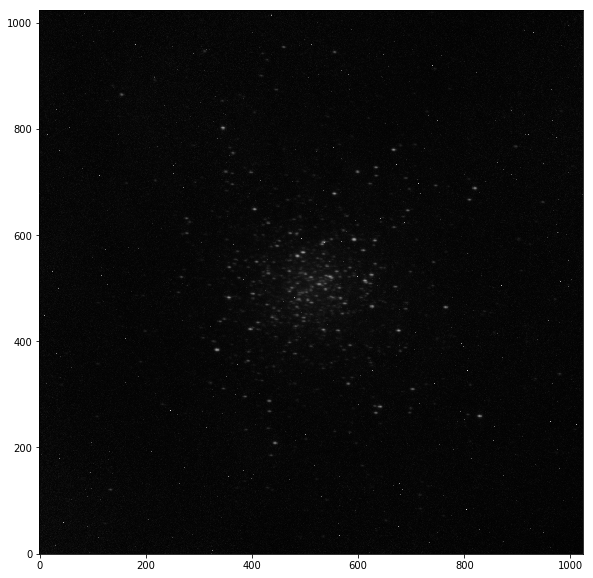

In [44]:
object_data = [fits.open(objects[i]) for i in range(len(objects))]

plt.figure(figsize=[10,10])
plt.imshow(object_data[6][0].data, cmap=plt.cm.gray, norm=LogNorm(),origin='lower')
#object_data[1][0].header

In [45]:
filters = [object_data[i][0].header['Filter'] for i in range(len(object_data))]
exptime = [object_data[i][0].header['exptime'] for i in range(len(object_data))]
names = objects

t = Table([names,filters,exptime], names=('Files','Filters','ExpTime'))

t

<Table length=12>
             Files              Filters ExpTime
             str31                str6  float64
------------------------------- ------- -------
M13_sdss_i_20190503_090800.fits  sdss_i   120.0
M13_sdss_i_20190503_084455.fits  sdss_i    60.0
M13_sdss_z_20190503_084627.fits  sdss_z    80.0
M13_sdss_z_20190503_092233.fits  sdss_z   160.0
M13_sdss_r_20190503_085306.fits  sdss_r   120.0
M13_sdss_i_20190503_085536.fits  sdss_i   120.0
M13_sdss_z_20190503_091030.fits  sdss_z   160.0
M13_sdss_r_20190503_091741.fits  sdss_r   120.0
M13_sdss_r_20190503_084324.fits  sdss_r    60.0
M13_sdss_g_20190503_090311.fits  sdss_g   120.0
M13_sdss_g_20190503_091520.fits  sdss_g   120.0
M13_sdss_z_20190503_085808.fits  sdss_z   160.0

# Bias

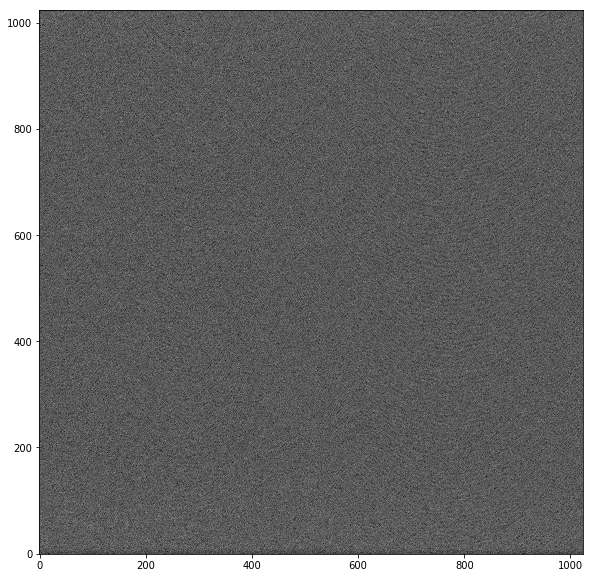

In [46]:
bias_data = [fits.open(bias[i]) for i in range(len(bias))]
plt.figure(figsize=[10,10])
plt.imshow(bias_data[1][0].data, cmap=plt.cm.gray, norm=LogNorm(),origin='lower')
#bias_data[8][0].header

1310.8249216079714

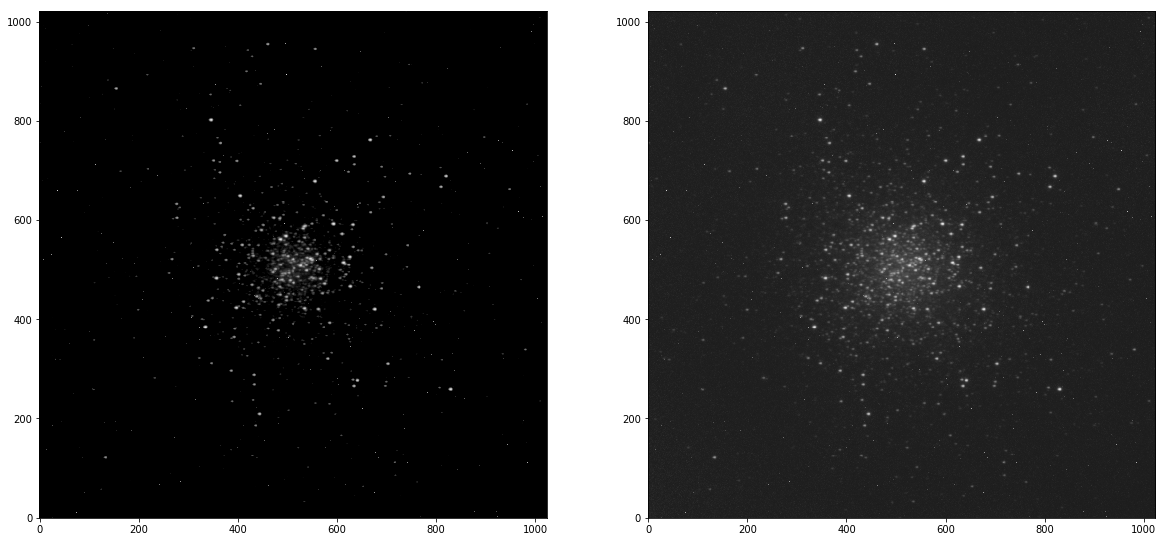

In [47]:
bias_total = np.zeros([1024,1024])
for i in range(len(bias)):
    bias_total += bias_data[i][0].data
bias_final = bias_total/3

fig,(ax1,ax2) = plt.subplots(1,2,figsize=[20,10])

ax1.imshow(object_data[0][0].data-bias_final, cmap=plt.cm.gray, norm=LogNorm(900),origin='lower')
ax2.imshow(object_data[0][0].data, cmap=plt.cm.gray, norm=LogNorm(900),origin='lower')
np.mean(bias_final)

# Overscan

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2102 / length of data axis 1                          
NAXIS2  =                 2050 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
OBSERVAT= 'APO'                / Per the IRAF observatory list.                 
TELESCOP= '3.5m'                                                                
INSTRUME= 'arctic'             / Instrument name                                
LATITUDE= +3.2780361000000E+01 / Latitude of telescope base                     
LONGITUD= -1.0582041700000E+02 / Longitude of telescope base                    
TIMESYS = 'TAI'                / Time system for DATE-OBS                       
UTC-TAI = -37.0             

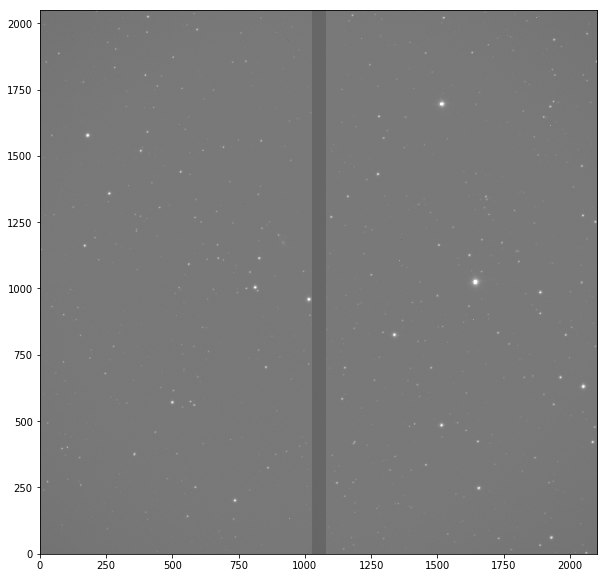

In [48]:
overscan = fits.open('Wolf1346/wolf1346_.0001.fits')

plt.figure(figsize=[20,10])
plt.imshow(overscan[0].data, cmap='gray', norm=LogNorm(10),origin='lower')

overscan[0].header


# Flat Fields

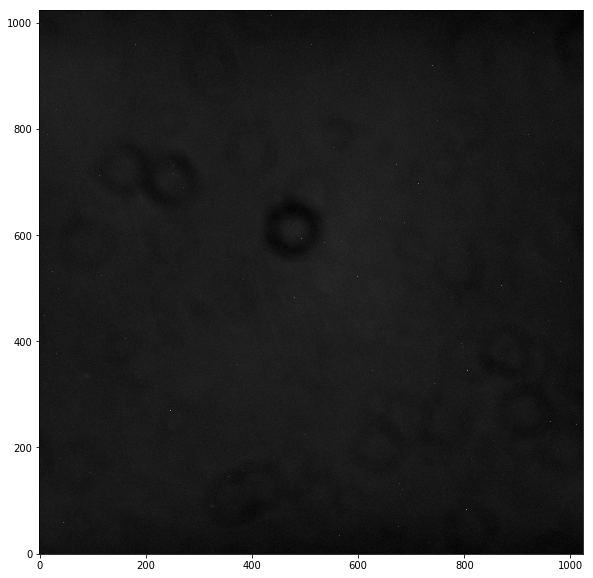

In [49]:
flat_data = [fits.open(flats[i]) for i in range(len(flats))]

plt.figure(figsize=[10,10])
plt.imshow(flat_data[0][0].data, cmap=plt.cm.gray, norm=LogNorm(),origin='lower')

In [50]:
filters = [flat_data[i][0].header['Filter'] for i in range(len(object_data))]
exptime = [flat_data[i][0].header['exptime'] for i in range(len(object_data))]
names = flats

t = Table([names,filters,exptime], names=('Files','Filters','ExpTime'))
t

<Table length=12>
         Files           Filters ExpTime
         str24             str6  float64
------------------------ ------- -------
domeflat_sdss_z_003.fits  sdss_z   39.64
domeflat_sdss_z_002.fits  sdss_z   39.45
domeflat_sdss_g_001.fits  sdss_g   11.55
domeflat_sdss_i_003.fits  sdss_i   14.57
domeflat_sdss_i_002.fits  sdss_i   14.47
domeflat_sdss_r_001.fits  sdss_r    6.98
domeflat_sdss_r_002.fits  sdss_r    7.13
domeflat_sdss_i_001.fits  sdss_i   13.29
domeflat_sdss_g_003.fits  sdss_g   12.08
domeflat_sdss_g_002.fits  sdss_g   11.93
domeflat_sdss_r_003.fits  sdss_r    7.15
domeflat_sdss_z_001.fits  sdss_z   38.01

In [51]:
flats_i = np.zeros([1024,1024])
flats_z = np.zeros([1024,1024])
flats_g = np.zeros([1024,1024])
flats_r = np.zeros([1024,1024])

for i in range(len(t['Filters'])):
    if t['Filters'][i] == 'sdss_i':
        flats_i += flat_data[i][0].data
    elif t['Filters'][i] == 'sdss_g':
        flats_g += flat_data[i][0].data
    elif t['Filters'][i] == 'sdss_z':
        flats_z += flat_data[i][0].data
    elif t['Filters'][i] == 'sdss_r':
        flats_r += flat_data[i][0].data

flats_i_final = flats_i/3
flats_g_final = flats_g/3
flats_z_final = flats_z/3
flats_r_final = flats_r/3

# Data Analysis: Photometry

In [52]:
import photutils

quad = fits.open('quadRU.fits')

img_max = np.max(quad[0].data)

finder = photutils.DAOStarFinder(238,7.0,exclude_border=True, peakmax= img_max - 1000)
stars = finder.find_stars(quad[0].data)
stars

<Table length=200>
  id      xcentroid      ...        flux                mag         
int64      float64       ...      float64             float64       
----- ------------------ ... ------------------ --------------------
    1  633.9317330632724 ... 1.0318053436153773 -0.03399443177562936
    2 111.55599719920147 ... 1.1370004974369732 -0.13940163672831957
    3 172.87649761173435 ... 28.755017770915533   -3.646784100831418
    4  587.6108909816617 ... 14.434797873238477  -2.8985267673635025
    5   550.623900630154 ...  3.573759930554131  -1.3828134378992818
    6 10.484717953709689 ... 2.6644619857671543  -1.0640238212102673
    7 306.89260611272425 ... 2.9692306181503145  -1.1816098256678444
    8 288.17135624896423 ...   3.16599476696311  -1.2512754817162508
    9  963.7129590219298 ... 3.3770137147042507    -1.32133206098169
   10  501.4322822277782 ...  3.456556390177497  -1.3466091158648452
  ...                ... ...                ...                  ...
  191  89.17975890301507 ...  6.827981595478118   -2.085730854556847
  192  758.3513864916064 ... 12.460453618040377  -2.7388346323379453
  193 212.06861854259284 ... 4.7234201723116644   -1.685641450009909
  194 445.50880910823145 ...  73.29915478102546   -4.662747416955718
  195   802.691137455935 ... 3.3124510487006265   -1.300373672504588
  196  993.8324752743493 ...  1.599276911349255  -0.5098091685258187
  197 101.84698457800916 ...  35.82228835809154  -3.8853833137454035
  198 187.42190273902898 ...  5.327158329546473  -1.8162390118262124
  199  713.3410106987839 ... 3.1093750272120717  -1.2316827655665006
  200  602.7746503153755 ... 5.2338393449422265  -1.7970509691089556

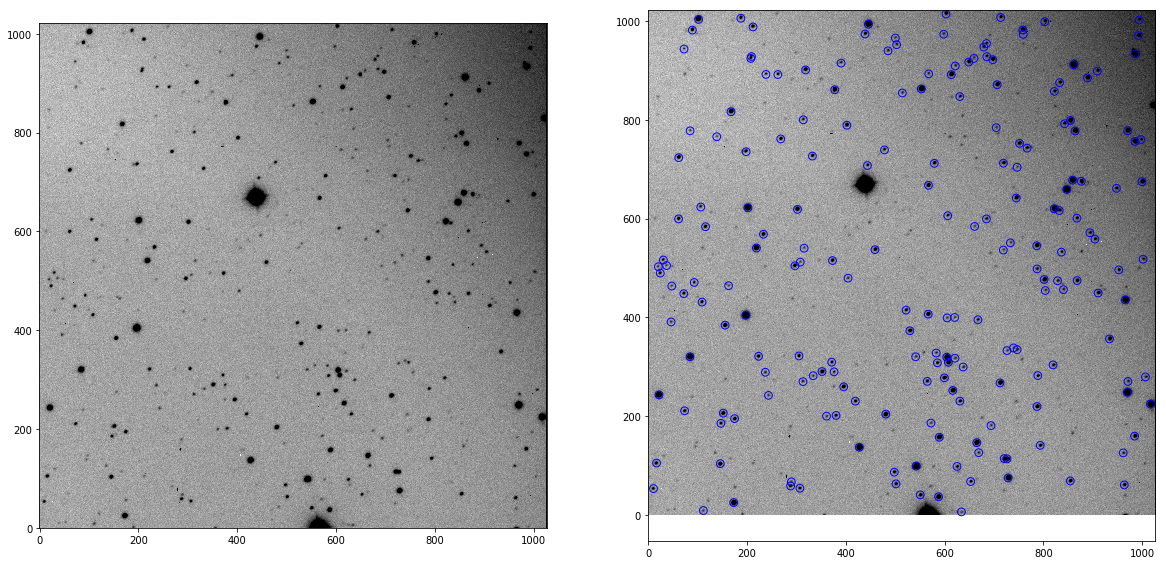

In [53]:
med = np.median(quad[0].data)
std = mad_std(quad[0].data)

marker_style = dict(color='tab:blue', linestyle=':', marker='o')

fig, (ax1,ax2) = plt.subplots(1,2,figsize=[20,10])
ax1.imshow(quad[0].data, cmap='gray_r',origin='lower', norm=LogNorm(vmin=med - 4*std, vmax=med + 10*std))
ax2.imshow(quad[0].data, cmap='gray_r',origin='lower', norm=LogNorm(vmin=med - 4*std, vmax=med + 10*std))
ax2.scatter(stars['xcentroid'],stars['ycentroid'],s = 60, facecolors='none', edgecolors='b')

## Aperture Method

In [54]:
apertures = photutils.CircularAperture((stars['xcentroid'],stars['ycentroid']),7.0)
ap_table = photutils.aperture_photometry(quad[0].data, apertures,method='exact')
ap_table

<QTable length=200>
  id       xcenter            ycenter          aperture_sum   
             pix                pix                           
int64      float64            float64            float64      
----- ------------------ ------------------ ------------------
    1  633.9317330632724  5.984347898442898  45229.03857472826
    2 111.55599719920147  8.760796532951211  44276.14876277154
    3 172.87649761173435 24.840040944554485 130048.90857705798
    4  587.6108909816617 36.725799738561165  91873.43918698737
    5   550.623900630154  40.46559799445158 55257.071712175355
    6 10.484717953709689  53.16785673415598  47721.26180531932
    7 306.89260611272425  53.94182631306558   49505.2686213757
    8 288.17135624896423  58.46112079322926  51347.56827125228
    9  963.7129590219298  60.69783465312444  54484.75853483027
  ...                ...                ...                ...
  191  89.17975890301507  981.5023429469621  58615.46372574288
  192  758.3513864916064  981.6521826015754   86140.9985043602
  193 212.06861854259284  987.8448657961708   52903.8245491528
  194 445.50880910823145  993.2261094830103 267563.96965128416
  195   802.691137455935  998.5351459542425  61590.59676834365
  196  993.8324752743493  1002.040513108044  65412.82275038233
  197 101.84698457800916 1003.0869662425861 143843.92847527252
  198 187.42190273902898 1005.4334098304595  55537.21651562184
  199  713.3410106987839 1006.9315267203174  57691.54034137429
  200  602.7746503153755 1014.1136323885172 61634.510902597554

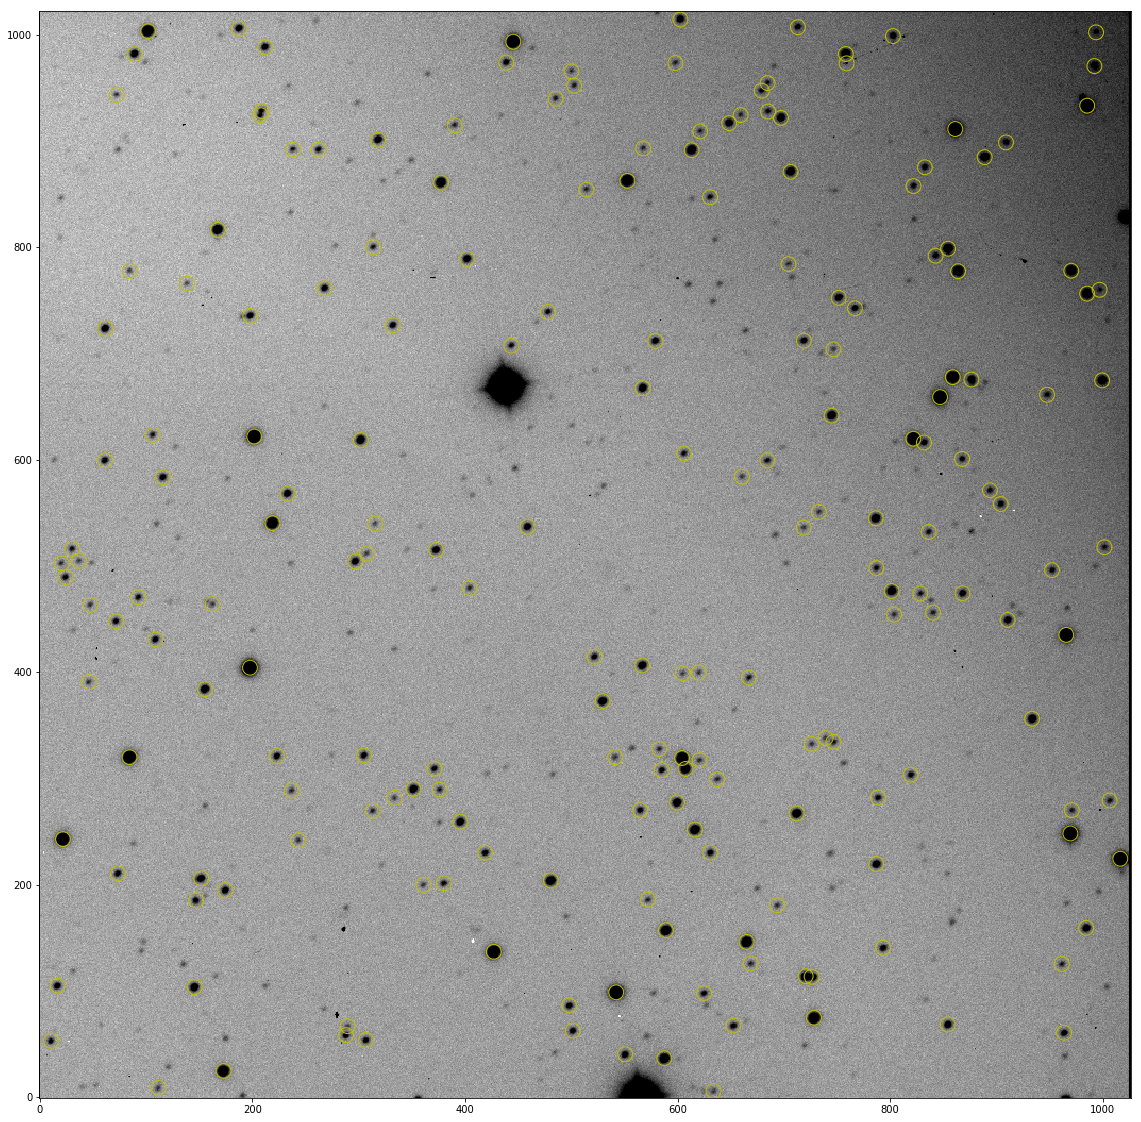

In [55]:
plt.figure(figsize=[30,20])
plt.imshow(quad[0].data, cmap='gray_r',origin='lower', norm=LogNorm(vmin=med - 4*std, vmax=med + 10*std))
apertures.plot(color='y')

## Annulus Method

In [147]:
annuli = photutils.CircularAnnulus((stars['xcentroid'],stars['ycentroid']),r_in=7.0,r_out=9.0)
an_table = photutils.aperture_photometry(quad[0].data, annuli,method='exact')
an_table

<QTable length=200>
  id       xcenter            ycenter          aperture_sum   
             pix                pix                           
int64      float64            float64            float64      
----- ------------------ ------------------ ------------------
    1  633.9317330632724  5.984347898442898 22560.147395931315
    2 111.55599719920147  8.760796532951211 26316.511593827934
    3 172.87649761173435 24.840040944554485 29101.952678539594
    4  587.6108909816617 36.725799738561165 29756.672270888557
    5   550.623900630154  40.46559799445158 28502.779517291387
    6 10.484717953709689  53.16785673415598  26156.86149033642
    7 306.89260611272425  53.94182631306558 26781.438174916737
    8 288.17135624896423  58.46112079322926 28305.598744181814
    9  963.7129590219298  60.69783465312444 28639.455448458735
  ...                ...                ...                ...
  191  89.17975890301507  981.5023429469621  25067.98659941366
  192  758.3513864916064  981.6521826015754  34501.43851773611
  193 212.06861854259284  987.8448657961708 25447.180452854634
  194 445.50880910823145  993.2261094830103 35063.403367285544
  195   802.691137455935  998.5351459542425   36364.7123885856
  196  993.8324752743493  1002.040513108044   40584.4956014861
  197 101.84698457800916 1003.0869662425861  28152.68027412449
  198 187.42190273902898 1005.4334098304595 25770.418528569124
  199  713.3410106987839 1006.9315267203174  32069.89114230972
  200  602.7746503153755 1014.1136323885172 25425.568704219946

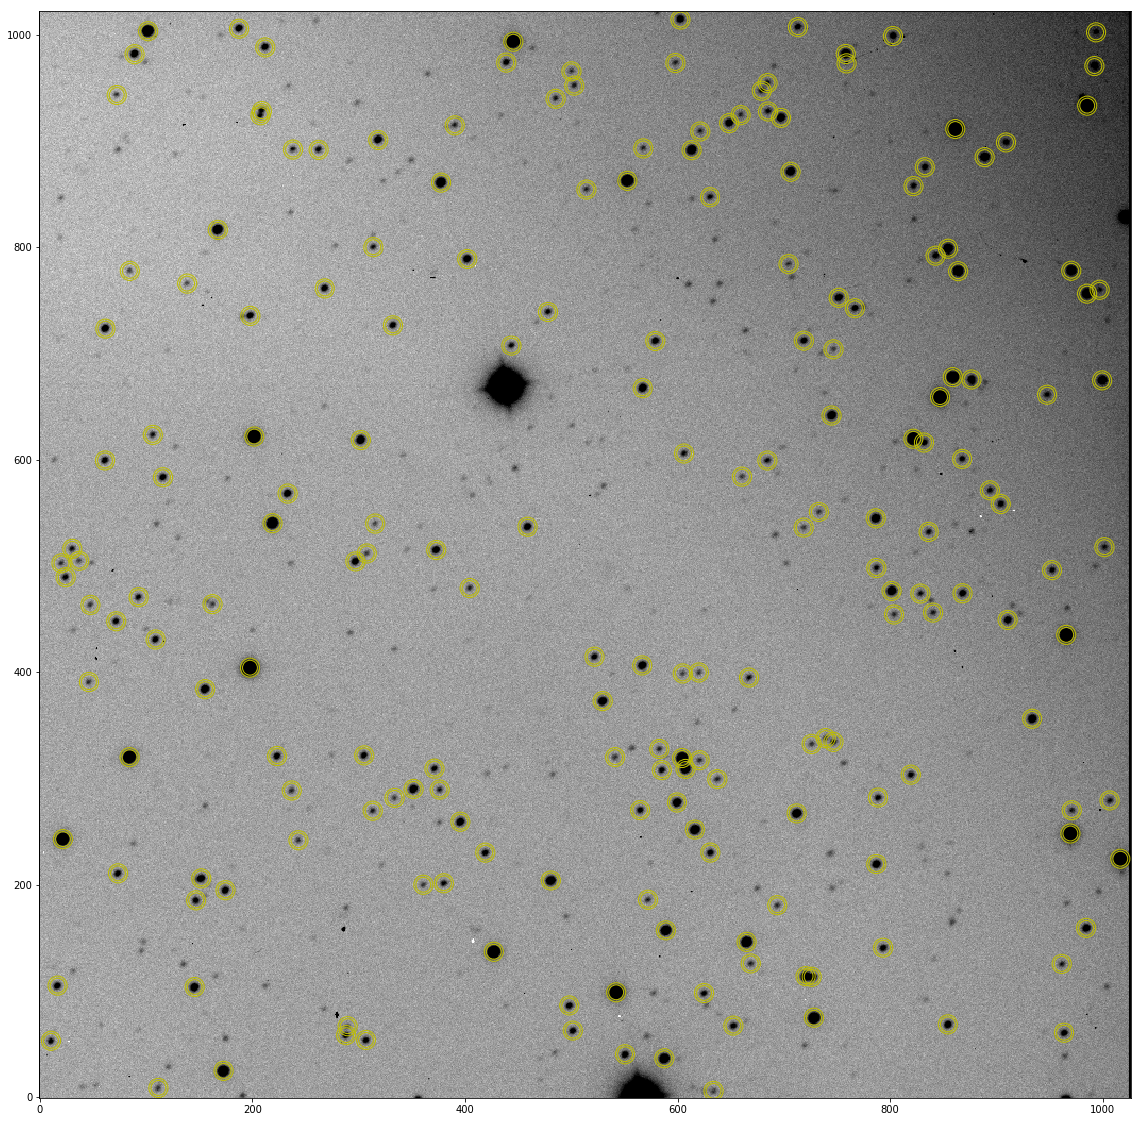

In [57]:
plt.figure(figsize=[30,20])
plt.imshow(quad[0].data, cmap='gray_r',origin='lower', norm=LogNorm(vmin=med - 4*std, vmax=med + 10*std))
annuli.plot(color='y')

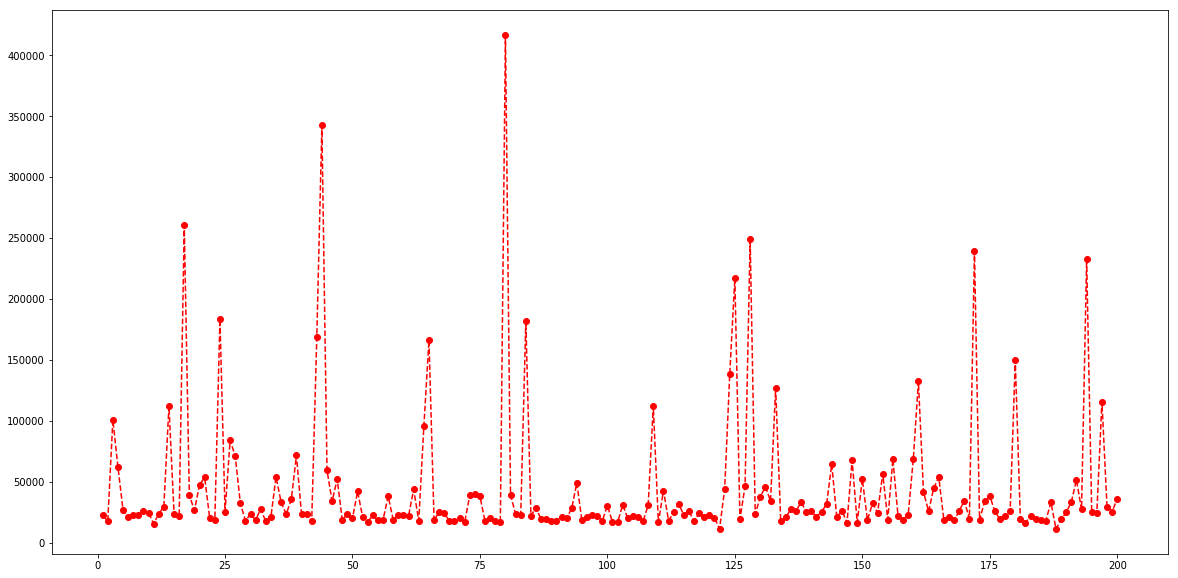

In [192]:
plt.figure(figsize=[20,10])
plt.plot(ap_table['id'],abs(ap_table['aperture_sum']-an_table['aperture_sum']),color='r',linestyle='--',marker='o')
#plt.scatter(an_table['id'],an_table['aperture_sum'],color='b')

## PSF

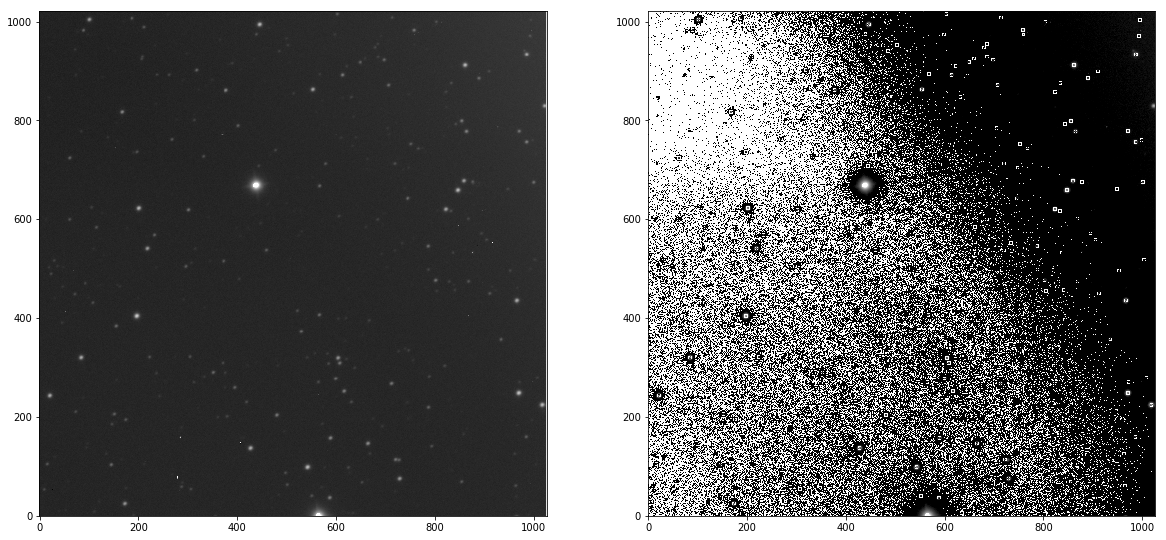

In [196]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.psf import BasicPSFPhotometry

bkgrms = MADStdBackgroundRMS()
std = bkgrms(quad[0].data)

daogroup = DAOGroup(7)
daofinder = photutils.DAOStarFinder(238,7.0, exclude_border=True, peakmax=img_max - 1000)
stars = finder.find_stars(quad[0].data)
mmm_bkg = MMMBackground()

psf_model = IntegratedGaussianPRF(sigma=7)
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True

photometry = BasicPSFPhotometry(group_maker=daogroup,
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_model,
                                fitter=LevMarLSQFitter(),
                                fitshape=(7,7), 
                                finder=daofinder)

result_tab = photometry(image=quad[0].data)
residual_image = photometry.get_residual_image()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=[20,10])
ax1.imshow(quad[0].data, cmap='gray',origin='lower', norm=LogNorm(100))
ax2.imshow(residual_image, cmap='gray',origin='lower', norm=LogNorm(100))

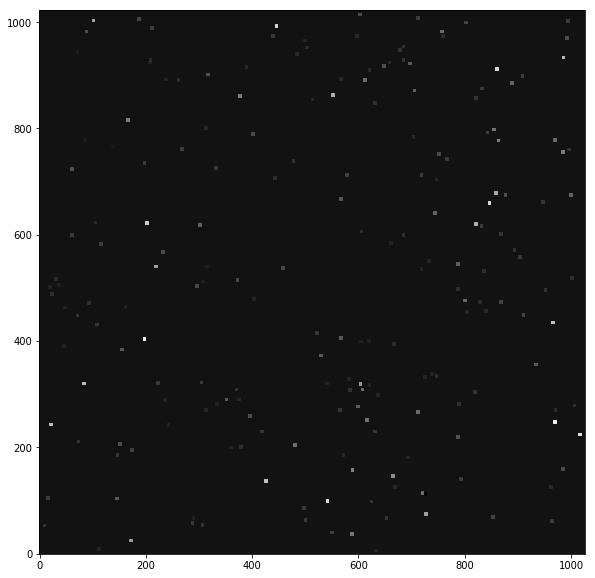

In [197]:
plt.figure(figsize=[20,10])
plt.imshow(quad[0].data-residual_image, cmap='gray',origin='lower',norm=LogNorm(200))

In [198]:
result_tab

<Table length=200>
       x_0                y_0         ...      flux_fit           flux_unc     
     float64            float64       ...      float64            float64      
------------------ ------------------ ... ------------------ ------------------
 633.9317330632724  5.984347898442898 ... 23718.399265578315 1466.9370853341932
111.55599719920147  8.760796532951211 ... 22752.982054298885 1717.8627707860346
172.87649761173435 24.840040944554485 ... 509255.50886658643  40247.35238909577
 587.6108909816617 36.725799738561165 ...  278461.8522755918 20881.241259325023
  550.623900630154  40.46559799445157 ...  75168.48383438362  5189.782061008438
10.484717953709689  53.16785673415598 ... 44558.729764243675 3960.6301408012528
306.89260611272425  53.94182631306558 ... 51644.595379101105  4226.753952971073
288.17135624896423  58.46112079322926 ...  57969.18432918281  4687.878161973039
 963.7129590219298  60.69783465312444 ...  68677.43032921455  4776.716351578777
 501.4322822277782  62.76448656382766 ...  64799.63133517737  5017.950288867285
               ...                ... ...                ...                ...
 89.17975890301507  981.5023429469621 ... 112580.09878474165  10313.54722476467
 758.3513864916064  981.6521826015754 ... 230517.97614004882 18541.942903920924
212.06861854259284  987.8448657961708 ...  78521.14603062108  6723.788700378655
445.50880910823145  993.2261094830103 ... 1292100.8643072732  108842.0603453416
  802.691137455935  998.5351459542425 ...  80713.50577211089  4858.702460010874
 993.8324752743493  1002.040513108044 ...   69265.4168062438 2203.0895278273047
101.84698457800916 1003.0869662425861 ...  603594.8312394314  50670.33849455978
187.42190273902898 1005.4334098304595 ...  92330.64887950718  8181.077206324116
 713.3410106987839 1006.9315267203174 ...  69542.78588494481  4581.008709129705
 602.7746503153755 1014.1136323885172 ... 102775.25186625606   7401.98789581348

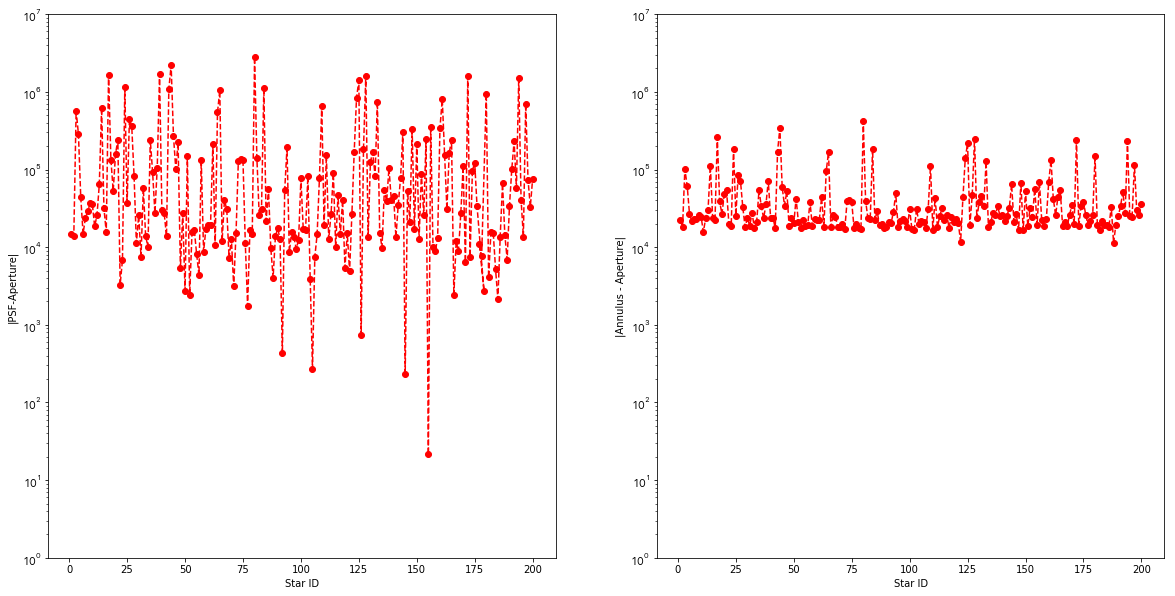

In [191]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[20,10])
ax1.plot(result_tab['id'],abs(result_tab['flux_fit']-ap_table['aperture_sum']),color='r',linestyle='--',marker='o')
ax2.plot(ap_table['id'],abs(an_table['aperture_sum']-ap_table['aperture_sum']),color='r',linestyle='--',marker='o')
ax1.set_ylim([1,1e7])
ax2.set_ylim([1,1e7])
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylabel('|PSF-Aperture|')
ax1.set_xlabel('Star ID')
ax2.set_ylabel('|Annulus - Aperture|')
ax2.set_xlabel('Star ID');